# Bird Species Image Classification



## Step 0: Import Libraries

We will start the project by importing necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Step 1: Data exploration and cleaning

When using other people's data to train our computer vision model, the very first step should be to familiarize oneself with how the data is organized. Specifically, our dataset folder has three subfolders: **test, train, and valid**. Inside these three subfolders, there are 525 invidiual subsubfolders for each bird species. We can see this by loading the ```birds.csv``` file using ```pandas``` which we already imported as ```pd```. Specifically the ```read_csv()``` method:

In [2]:
df = pd.read_csv("/kaggle/input/100-bird-species/birds.csv")
df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


Now that we have loaded the csv file given, let us see how many images do we have in the test, train and valid subfolders within the dataset parent folder.

In [3]:
train_imgs_count = df['data set'].value_counts()['train']
test_imgs_count = df['data set'].value_counts()['test']
valid_imgs_count = df['data set'].value_counts()['valid']
print(f"Number of train images: {train_imgs_count}")
print(f"Number of test images: {test_imgs_count}")
print(f"Number of valid images: {valid_imgs_count}")

Number of train images: 84635
Number of test images: 2625
Number of valid images: 2625


In [4]:
# data_dir = "/kaggle/input/100-bird-species/"
# print(df.shape)
# # limit the number of classes to most frequent 20 classes
# num_classes = 525
# df = df[df["labels"].isin(df["labels"].value_counts().index[:num_classes])]
# print(df.shape)

Great! The numbers match those mentioned in the [data card](https://www.kaggle.com/datasets/gpiosenka/100-bird-species). However we got these numbers from the csv file. What if because of minor oversights, there are discrepancies in the csv file vs the actual existence of these files? Let's quickly check

In [5]:
# collect missing files
import os
missing_files = []
data_dir = "/kaggle/input/100-bird-species/"
for i in tqdm(df["filepaths"], total=len(df)):
    if not os.path.exists(data_dir + i):
        missing_files.append(i)

# print how many missing files
print(len(missing_files))

  0%|          | 0/89885 [00:00<?, ?it/s]

165


Our suspicion was indeed correct! There are 165 files missing in the parent data folder: ``` /kaggle/input/100-bird-species```. So we will now remove the missing entries in our dataframe ```df``` in order for our model to train smoothly.

In [6]:
print(f'dataframe shape before removing the missing files: {df.shape}')
# remove the missing files
df = df[~df["filepaths"].isin(missing_files)]
print(f'dataframe shape after removing the missing files: {df.shape}')

dataframe shape before removing the missing files: (89885, 5)
dataframe shape after removing the missing files: (89720, 5)


## Step 2: Data preparation for model
Machine learning models are trained on datasets in order to be able to learn patterns in data. Here our goal is to transform our image dataset into numeric matrices. The most important step here is to ensure that the model is being trained on data that actually represents the samples which in our case are images of birds. Python provides libraries such as Python Image Library (PIL) which provides the ```Image.open()``` method that lets us represent images with matrices. Since we have 84635 images of 525 bird species, applying the ```Image.open()```  function on every image individually would be tedious and/or impossible. So 

Since our dataset is already divided into test, train, and validation sets, we can begin data preparation for modeling by creating three different dataframes for each set.

In [7]:
# df dataset has "data set" column which is "train", "test" and "valid" lets split the data into train, test and valid
train_df = df[df["data set"]=="train"]
test_df = df[df["data set"]=="test"]
valid_df = df[df["data set"]=="valid"]


These three dataframes: ```train_df```, ```test_df```, and ```valid_df``` will be the input parameters through which an ```ImageDataset``` object will build dataloaders. Let's build this dataloader class. Our custom```ImageDataset``` class must implement three functions: ```__init__(self, df, transform=None)```,  ```__len__(self)``` and ```__getitem__(self, index)``` . Let us discuss the purposes of these three functions:


### ```__init__(self, df, transform=None)```

This function is run once when instantiating the ```ImageDataset``` object. Since three dataframes we have created have the paths to our images and their labels, passing the relevant dataframe would be sufficient in initializing the directory containing the images and their annotations/labels. Another parameter is the transforms which we will discuss shortly. 


### ```__len__(self)```

This function returns the number of samples in our dataset.


### ```__getitem__(self, index)```

This function loads and returns a sample from the dataset at the given index ```index```. Based on the index, it identifies the image’s location on disk,  opens and identifies the image file at the given index, and then applies the transforms provided by us.

In [8]:
class ImageDataSet(torch.utils.data.Dataset):
    def __init__(self,df, transform=None):
        super().__init__()
        self.df = df
        self.transform = transform
        self.labels2idx = {label: i for i, label in enumerate(df["labels"].unique())}


    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = Image.open(data_dir +  row["filepaths"])

        if self.transform:
            image = self.transform(image)
#         image = image / 255.0
        return image, self.labels2idx[row["labels"]]



# for sample, image in train_loader:
#     print(image.shape)


In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomRotation(degrees=20),
    
    transforms.ToTensor(),
#     transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

In [10]:
train_dataset = ImageDataSet(train_df, transform=train_transform)
valid_dataset = ImageDataSet(valid_df, transform=valid_transform)
test_dataset = ImageDataSet(test_df, transform=valid_transform)

batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

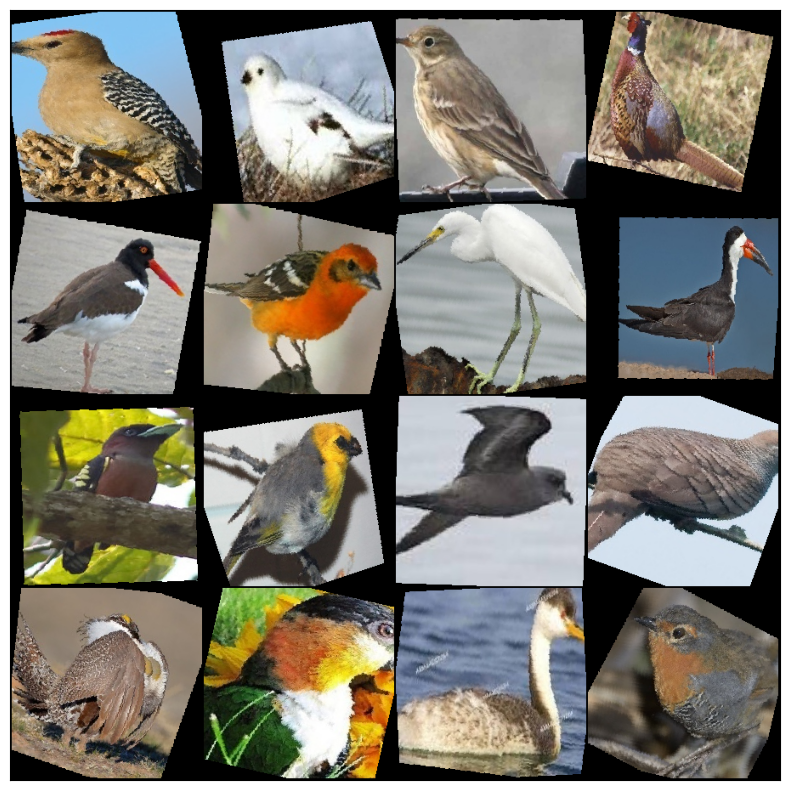

In [11]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break


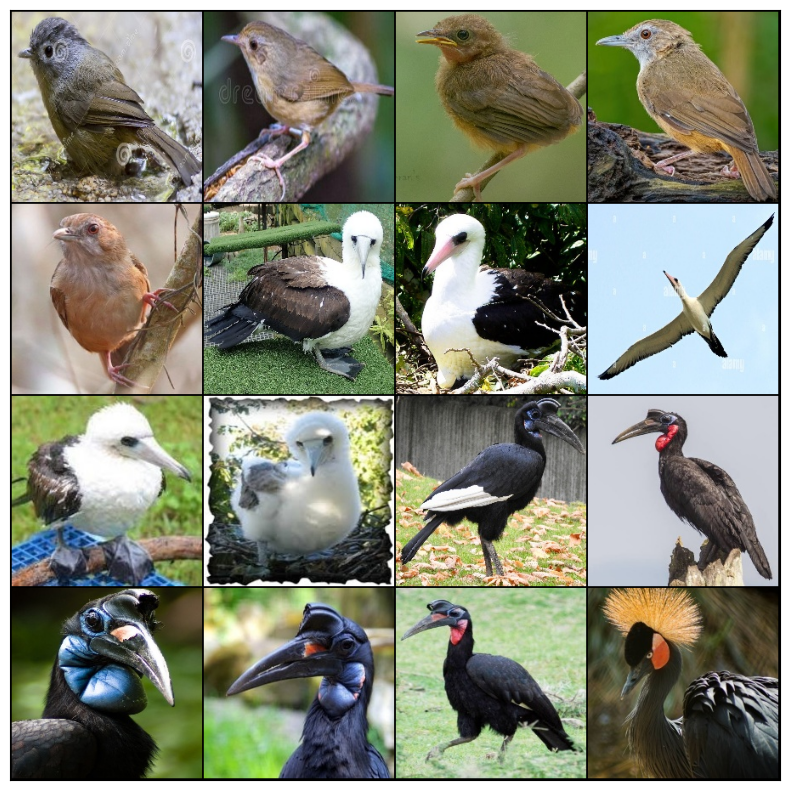

In [12]:
for images, labels in valid_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break


In [13]:
import torchvision.models as models

model = models.resnet50()
fc_in_features = model.fc.in_features
model.fc = nn.Linear(fc_in_features, 525)


# model = models.vgg16(pretrained = True)

# ### Modifying last few layers and no of classes
# # NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
# model.classifier = nn.Sequential(
#     nn.Linear(25088, 4096, bias = True),
#     nn.ReLU(inplace = True),
#     nn.Dropout(0.4),
#     nn.Linear(4096, 2048, bias = True),
#     nn.ReLU(inplace = True),
#     nn.Dropout(0.4),
#     nn.Linear(2048, num_classes),
# )


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float(acc.sum() / len(acc))
    return round(acc, 4)

In [16]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 5

history = {
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": []
}

best_loss = np.inf
best_acc = 0
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    model.train()
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criteria(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        train_acc += calc_accuracy(labels.cpu(), outputs.cpu())
        
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)

    valid_loss = 0
    valid_acc = 0
    model.eval()
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criteria(outputs, labels)
        valid_loss += loss.item()
        valid_acc += calc_accuracy(labels.cpu(), outputs.cpu())
        
    valid_loss = valid_loss / len(valid_loader)
    valid_acc = valid_acc / len(valid_loader)

    history["valid_loss"].append(valid_loss)
    history["valid_acc"].append(valid_acc)

#     if valid_loss < best_loss:
#         best_loss = valid_loss
#         print("Saving the best model")
#         torch.save(model.state_dict(), "best_model.pt")
        
    if valid_acc > best_acc:
        best_acc = valid_acc
        print(f"Saving the best model at epoch {epoch}")
        torch.save(model.state_dict(), "best_model.pt")
    print(f"Epoch: {epoch} Train Loss: {train_loss:.2f} Train Acc: {train_acc:.2f} Val Loss: {valid_loss:.2f} Val Acc: {valid_acc:.2f}")

  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Saving the best model at epoch 0
Epoch: 0 Train Loss: 5.28 Train Acc: 0.04 Val Loss: 3.90 Val Acc: 0.16


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Saving the best model at epoch 1
Epoch: 1 Train Loss: 3.32 Train Acc: 0.27 Val Loss: 2.35 Val Acc: 0.47


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Saving the best model at epoch 2
Epoch: 2 Train Loss: 2.25 Train Acc: 0.48 Val Loss: 1.38 Val Acc: 0.66


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Saving the best model at epoch 3
Epoch: 3 Train Loss: 1.71 Train Acc: 0.59 Val Loss: 1.14 Val Acc: 0.71


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Saving the best model at epoch 4
Epoch: 4 Train Loss: 1.39 Train Acc: 0.66 Val Loss: 1.09 Val Acc: 0.73


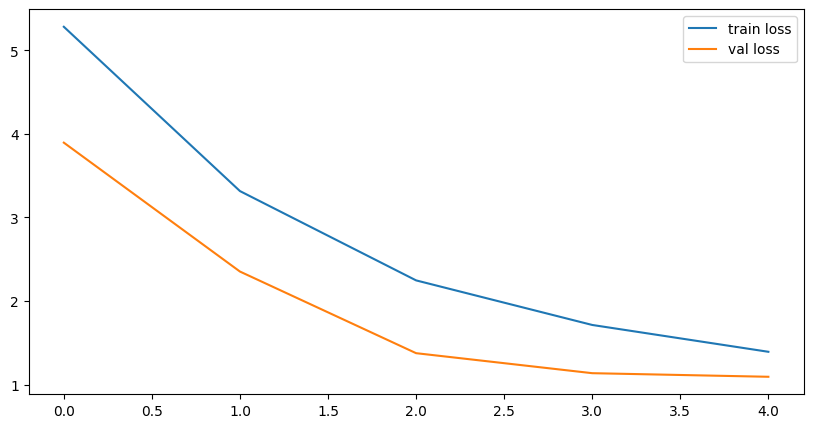

In [17]:
# plot the loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["valid_loss"], label="val loss")
plt.legend()
plt.show()

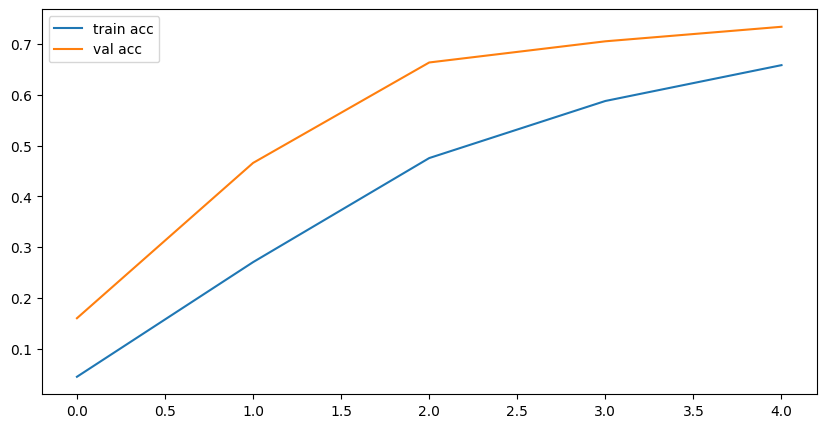

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["valid_acc"], label="val acc")
plt.legend()
plt.show()

In [19]:
# test the model

model.load_state_dict(torch.load("best_model.pt"))
model.eval()
test_acc = 0
for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += calc_accuracy(labels.cpu(), outputs.cpu())
test_acc = test_acc / len(test_loader)
print(f"Test Acc: {test_acc}")

  0%|          | 0/164 [00:00<?, ?it/s]

Test Acc: 0.7632115853658537


In [20]:
import pickle 

outfile = 'resnet50_model.pkl'

with open(outfile, 'wb') as pickle_file:
    pickle.dump(torch.load("best_model.pt"), pickle_file)

In [21]:
from fastai.vision.all import *
import fastai

learn = load_learner('/kaggle/working/resnet50_model.pkl')
def classify_image(img):
    pred, idx, prbs = learn.predict(img)
    dict_all = dict(zip(categories, map(float, prbs)))
    return dict(sorted(dict_all.iteritems(), key=operator.itemgetter(1), reverse=True)[:5])

print(classify_image('/kaggle/input/100-bird-species/test/ABYSSINIAN GROUND HORNBILL/4.jpg'))

RuntimeError: Invalid magic number; corrupt file?